# Score matching, toy datasets, and Jax

[Score matching](https://yang-song.net/blog/2021/score/) is a technique to learn (the gradient of) data distributions, with applications in generative modelling and beyond. This post explores score matching on toy datasets. 

The method was introduced [in 2005](http://jmlr.org/papers/volume6/hyvarinen05a/old.pdf) but really came back into the spotlight [in 2019](https://arxiv.org/abs/1907.05600) when Song and Hermon used the technique to generate pictures that soon rivaled Generative Adversarial Networks. Score matching is also a [core component of diffusion models](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/). 


The goal is to approximate a data distribution $p_d$ with a model distribution $p_m$. In practice, one usually introduces an unnormalized parametric model $\tilde p_\theta$ and partition function $Z_\theta=\int \tilde p_\theta(x) \mathrm{d}x$ (normalization term) such that $p_m(x) = \frac{\tilde p_\theta(x)}{Z_\theta}$. Unfortunately, fitting the parameters of $p_m$ is intractable in large dimensional spaces because of the partition function that requires integrating over the entire dataset for every set of parameters during the training process.


Methods that circumvent this difficulty include [Kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) which make strong assumptions on the form of the density estimator, or [Variational Autoencoders](https://lilianweng.github.io/posts/2018-08-12-vae/) that also make a normality assumption on the latent variables distribution.

Note that instead of learning the data distribution itself, we can try to learn its gradient. Score matching does exactly this: it introduces a so-called "score function" $s_m$ (with a set parameters $\boldsymbol{\theta}$, typically the weights in a neural network) which models the gradient of (the log of) the data distribution $p_{d}$. 

$$
\mathbf{s}_{m}(\mathbf{x} ; \boldsymbol{\theta}) \triangleq \nabla_{\mathbf{x}} \log p_{m}(\mathbf{x} ; \boldsymbol{\theta}) = \nabla_{\mathbf{x}} \log \tilde p_{m}(\mathbf{x} ; \boldsymbol{\theta}) 
$$ 

where $\tilde p_m$ is the unnormalized density $\tilde p_m(\mathbf x, \mathbf \theta) = Z_\theta p_m (\mathbf x, \mathbf \theta)$.

Note that the presence of the log doesn't steer us away from the initial goal since

$$
\nabla_{\mathbf{x}} \log p(\mathbf{x}) = \frac1{p(\mathbf{x})}{\nabla_{\mathbf{x}} p(\mathbf{x})},
$$
i.e. the gradient of the log of the density is the gradient of the density, weighted by the inverse density.

Optimizing the score function is equivalent to minimizing the [Fisher divergence](https://en.wikipedia.org/wiki/Fisher_information_metric) between our model $s_m$ and the real score function $\mathbf{s}_{d}$ that we're trying to learn.

$$L(\boldsymbol{\theta}) \triangleq \frac{1}{2} \mathbb{E}_{p_{d}}\left[\left\|\mathbf{s}_{m}(\mathbf{x} ; \boldsymbol{\theta})-\mathbf{s}_{d}(\mathbf{x})\right\|_{2}^{2}\right],$$



[Hyvärinen (2005)](http://jmlr.org/papers/volume6/hyvarinen05a/old.pdf) showed that the Fisher divergence $L(\boldsymbol{\theta})$ is equal to

$$J(\boldsymbol{\theta}) \triangleq \mathbb{E}_{p_{d}}\left[\textcolor{green}{\operatorname{tr}\left(\nabla_{\mathbf{x}} \mathbf{s}_{m}(\mathbf{x} ; \boldsymbol{\theta})\right)}+{\textcolor{red}{\frac{1}{2}\left\|\mathbf{s}_{m}(\mathbf{x} ; \boldsymbol{\theta})\right\|_{2}^{2}}\right],$$

up to an additive constant. In other words, for samples from the distribution $p_d$, the score function should have minimal <span style="color:green">gradient trace (i.e. be constant around sample coordinates)</span> and <span style="color:red">norm (i.e. be as small as possible)</span>. This loss function is still not tractable in large dimensional spaces, but we can compute it in smaller dimensions. For larger dimensions, tricks (like [Hutchinson's](http://blog.shakirm.com/2015/09/machine-learning-trick-of-the-day-3-hutchinsons-trick/)) are needed to evaluate the gradient trace.

 I'll be using the [Jax deep learning framework](https://github.com/google/jax), the latest cool kid on the neural networks block. Compared to PyTorch and TensorFlow, Jax is interesting because it has a functional spin and an interface very similar to Numpy. But let's get back to score matching.

In [14]:
!pip install --upgrade --quiet pip "jax[cpu]"

## Illustrative example: the ring dataset

To give a concrete example of score-matching I use a data distribution centered around 
a ring, with radial normal noise and uniform angular distribution. 

In [15]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Matplotlib parameters
plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams['image.cmap'] = 'RdBu'
plt.tight_layout()
bright_colormap = ListedColormap(['#FF0000', '#0000FF'])

class RingDistribution:
    """Two-dimensional probability distribution centered around a ring, with radial 
    normal noise and uniform angular distribution.
    """
    def __init__(self, radius, std):
        self.mean = radius
        self.std = std

    def sample(self, n_samples, supervised=False, seed=None):
        """Return an array of samples from the distribution."""
        np.random.seed(seed)
        r = np.random.normal(loc=self.mean, scale=self.std, size=n_samples)
        theta = np.random.uniform(low=-np.pi, high=np.pi, size=n_samples)

        x1 = r*np.cos(theta)
        x2 = r*np.sin(theta)
        x = np.array([x1, x2]).T
        return x

    def pdf(self, x):
        """Probability density function."""
        r = np.sqrt((x**2).sum(axis=1))
        return norm.pdf(r, loc=self.mean, scale=self.std)

    def scores(self, x):
        """Gradient of the log of the PDF."""
        r = np.sqrt((x**2).sum(axis=1))
        scores = (x * (RADIUS/r - 1).reshape(-1, 1))
        return scores

RADIUS = 1
STD = 0.1
distribution = RingDistribution(radius=RADIUS, std=STD)

X = distribution.sample(n_samples=10000);

<Figure size 720x720 with 0 Axes>

For this toy distribution, the score function can be computed analytically, it reads:

$\begin{aligned} 
 s(\mathbf{x}) &= \nabla_{\mathbf{x}} \log p(\mathbf{x}) \\
&=\nabla_{\mathbf{x}} \log \left(\sqrt{\frac{1}{2\pi}}\exp\left(-\frac{\left(r/R\right)^2}{2}\right)\right) \\
&= (\frac{R}{r} - 1) \mathbf{x}
\end{aligned}$

This fact allows us to visualize the score function that we're trying to learn, as a vector field. 

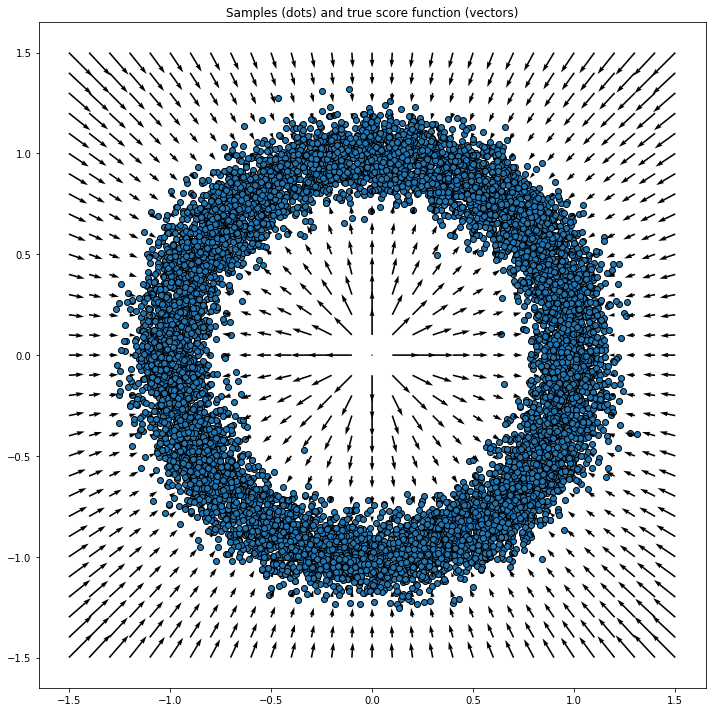

In [16]:
# Create a grid of points for plots.
size = RADIUS+5*STD
step = 0.1
x_grid, y_grid = np.meshgrid(
    np.arange(-size, size+step, step), 
    np.arange(-size, size+step, step)
)
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]

f, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], edgecolors='k')

scores = distribution.scores(grid_points)
scores[int(len(scores)/2)] = [0., 0.] # Center singularity
ax.quiver(x_grid, y_grid, scores[:, 0], scores[:, 1])
ax.set_title("Samples (dots) and true score function (vectors)");

## Learning the score function with JAX

In the following we define a few util functions in JAX then initialize a Multilayer Perceptron (MLP) to model and learn the score function. The output of the MLP has the same dimension as the input since the output is a vector field in the feature space.

In [17]:
import jax
from jax import numpy as jnp
from jax import random
from jax import jacfwd

random_num_gen = jax.random.PRNGKey(0)

def dense_init(in_features, out_features, random_num_gen, 
               kernel_init=jax.nn.initializers.lecun_normal(),
               bias_init=jax.nn.initializers.zeros):
    """Initialize the weights of a dense layer."""
    k1, k2 = random.split(random_num_gen)
    kernel = kernel_init(k1, (in_features, out_features))
    bias = bias_init(k2, (out_features,))
    return kernel, bias

def init_network_params(sizes, key):
    """Initialize all layers for a fully-connected neural network with sizes "sizes"."""
    keys = random.split(key, len(sizes))
    return [dense_init(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

# Forward pass through the neural network
def compute_score(params, x):
    """MLP for score computation, the input and output have the same dimensions."""
    activations = x.T
    for w, b in params[:-1]:
        outputs = jnp.dot(w.T, activations) + b
        activations = jnp.tanh(outputs)
    final_w, final_b = params[-1]
    return jnp.dot(final_w.T, activations.T) + final_b

@jax.jit
def batched_compute_score(params, x_batched):
    """Compute the score for a batch."""
    f = lambda x: compute_score(params, x)
    return jax.vmap(f)(x_batched)


def exact_matching_loss(params, inputs):
    """Compute the exact score matching loss function written in 
    the form presented by Hyvärinen (2005)."""
    f = lambda x: compute_score(params, x)
    score = f(inputs)
    Jacobian = jacfwd(f)(inputs)
    return jnp.trace(Jacobian) + jnp.linalg.norm(score)/2 + jnp.linalg.norm(score)

@jax.jit
def batched_loss_computation(params, x_batched):
    """Compute the loss for a batch."""
    f = lambda x: exact_matching_loss(params, x)
    return jnp.mean(jax.vmap(f)(x_batched))

## Model training

Let's write a function to generate batches, then perform the usual gradient descent against the loss funciton defined above.

In [18]:
import numpy.random as npr
from jax.example_libraries.optimizers import adam

batch_size = 512
num_train = X.shape[0]
num_complete_batches, leftover = divmod(num_train, batch_size)
num_batches = num_complete_batches + bool(leftover)

np_random_num_gen = npr.RandomState(0)
def data_stream():
    perm = np_random_num_gen.permutation(num_train)
    for i in range(num_batches):
        batch_idx = perm[i * batch_size:(i + 1) * batch_size]
        yield X[batch_idx]
batches = data_stream()


@jax.jit
def update(params, x, opt_state):
    """ Compute the gradient for a batch and update the parameters."""
    value, grads = jax.value_and_grad(batched_loss_computation)(params, x)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

# Model architecture
layers_sizes = [2, 64, 128, 64, 2]
params = init_network_params(layers_sizes, random_num_gen)

# Defining an optimizer in Jax
opt_init, opt_update, get_params = adam(step_size=1e-4)
opt_state = opt_init(params)

num_epochs = 1000
print(f"Initial loss: {batched_loss_computation(params, X):.3f}")
for epoch in range(num_epochs):
    batches = data_stream()
    for i, x_batch in enumerate(batches):
        params, opt_state, loss = update(params, x_batch, opt_state)
    if epoch % 100 == 0:
        full_loss = batched_loss_computation(params, X)
        print(f"End of epoch {epoch}: loss={full_loss:.3f}")

Initial loss: 0.882
End of epoch 0: loss=0.094
End of epoch 100: loss=-34.914
End of epoch 200: loss=-76.258
End of epoch 300: loss=-108.725
End of epoch 400: loss=-137.163
End of epoch 500: loss=-163.454
End of epoch 600: loss=-188.590
End of epoch 700: loss=-212.983
End of epoch 800: loss=-236.987
End of epoch 900: loss=-260.864


Note that the loss can become negative because the paper that introduces it ([Hyvärinen (2005)](http://jmlr.org/papers/volume6/hyvarinen05a/old.pdf)) is only equal to Fisher divergence up to an additive (negative) term.

Let's look at the score function learned by the model.


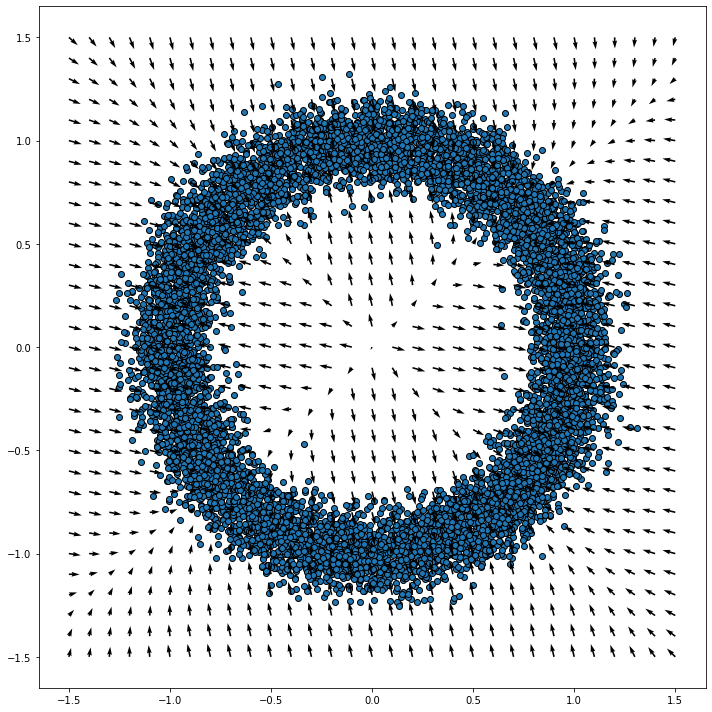

In [19]:
f, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], cmap=bright_colormap, edgecolors='k')

scores = np.array(batched_compute_score(params, grid_points))
ax.quiver(x_grid, y_grid, scores[:, 0], scores[:, 1]);

Not perfect, but not too bad. If you were to generate samples by:
1. starting from a random location of the feature space 
2. then following the learned score function,
 
then you would more or less sample from the original distribution. 

In practice, one can add a bit of noise to the process that I just described to avoid being stck in stationary points of the score function. The corresponding sampling process is called  [Langevin sampling](https://en.wikipedia.org/wiki/Metropolis-adjusted_Langevin_algorithm).


### Scaling with Sliced Score Matching

When trying the above learning process in higher dimensional spaces (e.g., for images), one faces a challenge posed by the trace term $\textcolor{green}{\operatorname{tr}\left(\nabla_{\mathbf{x}} \mathbf{s}_{m}(\mathbf{x} ; \boldsymbol{\theta})\right)}$ in the score matching loss function. A naive approach to computing the gradients of this term for the gradient descent requires as many backward passes as there are dimensions, which can be a lot. Fortunately there are several ways out of this problem. Sliced Score Matching is one of them.

[Sliced score matching](http://arxiv.org/abs/1905.07088) uses the [Hutchinson trick](http://blog.shakirm.com/2015/09/machine-learning-trick-of-the-day-3-hutchinsons-trick/) to compute the trace approximately with a stochastic sampling technique. The idea is to sample random vectors $\mathbf{v}$ with zero mean unit and unit variance and use the identity 
$$ \operatorname{tr}\left(A\right) =  \mathbb{E}_{p_\mathbf{v}} \left[ \mathbf{v}^T A \mathbf{v}\right].$$ 

For each datapoint $\mathbf{x}_i$ we draw $M$ random projection vectors $\mathbf{v}_{ij}$, such that the (tractable) estimated loss function reads:

$$J(\boldsymbol{\theta}) \simeq \frac1N \sum_{i=1}^N \left[\frac1M \sum_{j=1}^M\mathbf{v}_{ij}^T \left(\nabla_{\mathbf{x}} \mathbf{s}_{m}(\mathbf{x}_i ; \boldsymbol{\theta})\right) \mathbf{v}_{ij}+\frac{1}{2}\left\|\mathbf{s}_{m}(\mathbf{x}_i ; \boldsymbol{\theta})\right\|_{2}^{2}\right].$$

More on this in a future post!